# Fruit Classification Notebook - Using ResNet152

## Importing Libraries

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU, Dropout
from keras.optimizers import Adam, SGD

## Functions

In [2]:
# Function to display random images from each folder
def display_random_images(train_path):
    folders = os.listdir(train_path)
    
    # Iterate over each folder
    for folder in folders:
        print(f"Images from {folder}:")
        folder_path = os.path.join(train_path, folder)
        images = os.listdir(folder_path)
        
        # Display two random images from the folder side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        for i in range(2):
            random_image = random.choice(images)
            img_path = os.path.join(folder_path, random_image)
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

# Function to count instances for each class in a directory
def count_instances(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

# Function to plot images, their actual and predicted labels
def plot_images_with_labels(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.title(f"Actual: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

def plot_model_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

def plot_model_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

## Data Reading 

In [2]:
    train_path = './train/'
    val_path = './valid/'
    test_path = './test/'

    # Data augmentation
    train_datagen = ImageDataGenerator(
        zoom_range=0.2,        
        width_shift_range=0.1,  
        height_shift_range=0.1,   
        shear_range=0.2,          
        rotation_range=25        
    )
    test_datagen = ImageDataGenerator()  # No augmentation for test data
    val_datagen = ImageDataGenerator()  # No augmentation for validation data

    # Loading datasets using flow_from_directory
    train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True)
    test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=False)
    val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=False)


Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


Images from Apple:


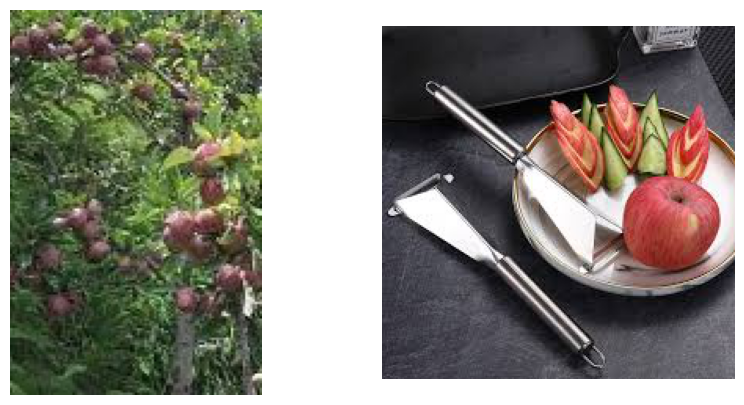

Images from Banana:


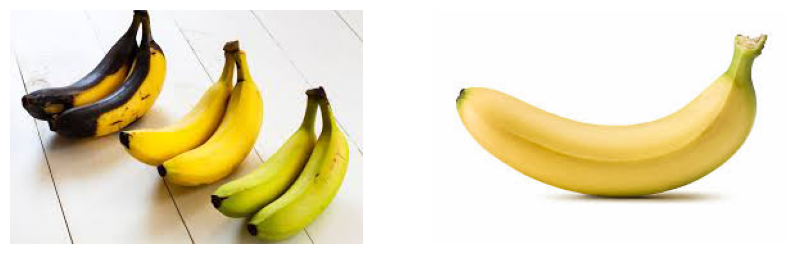

Images from Grape:


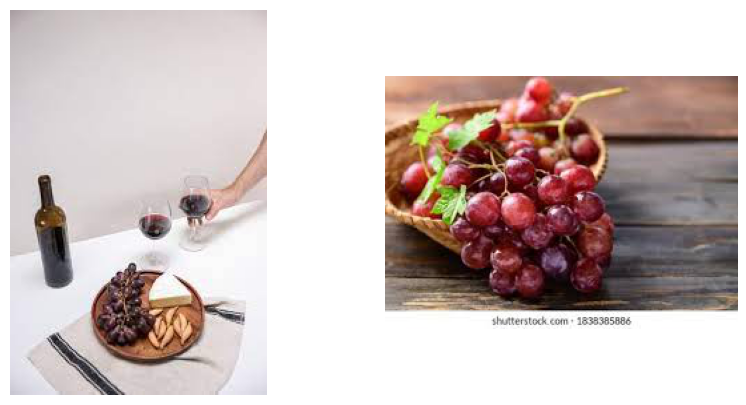

Images from Mango:


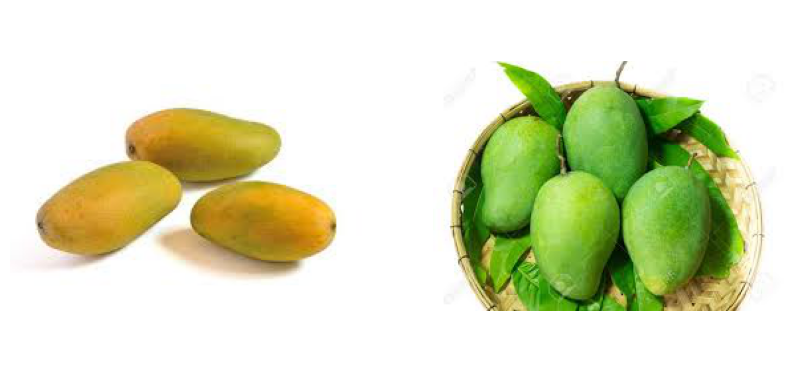

Images from Strawberry:


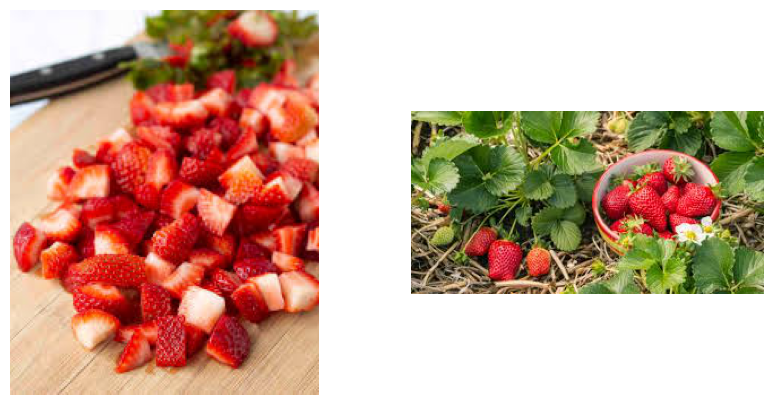

In [9]:
# Display some images from each category
display_random_images(train_path)

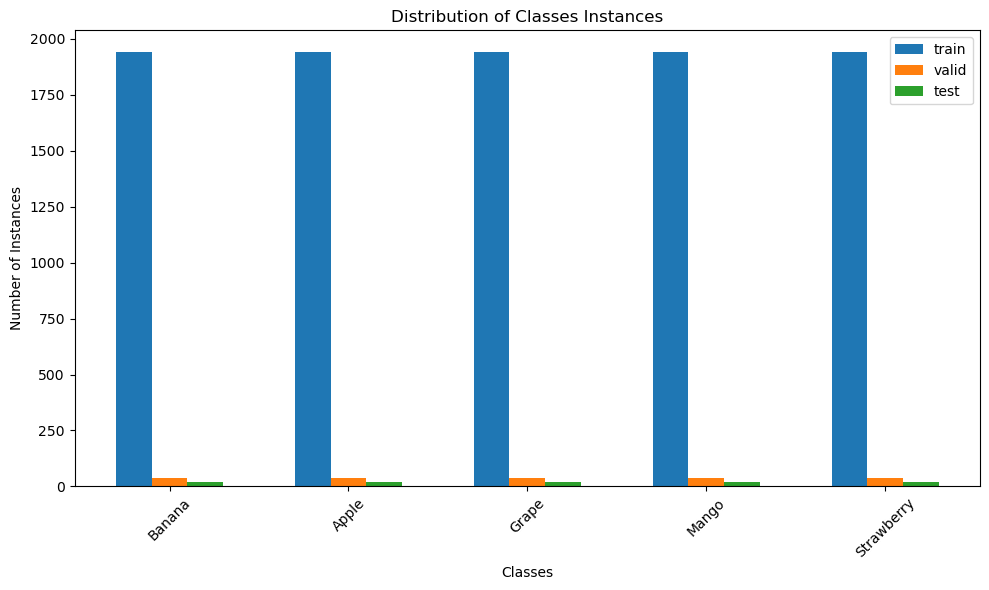

In [23]:
# Count instances for each class in train, validation, and test sets
datasets = [train_path, val_path, test_path]
class_counts = {cls: sum(count_instances(dataset).get(cls, 0) for dataset in datasets) for cls in set().union(*(count_instances(dataset).keys() for dataset in datasets))}

# Sort classes based on train set counts
sorted_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
classes = [cls for cls, _ in sorted_classes]
train_counts = [class_counts[cls] for cls in classes]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(len(classes))

for i, dataset in enumerate(datasets):
    counts = [count_instances(dataset).get(cls, 0) for cls in classes]
    plt.bar([j + i * bar_width for j in index], counts, bar_width, label=dataset.split('/')[-2])

plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes Instances')
plt.xticks([i + bar_width for i in index], classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


So we can see here is that the dataset is balanced among the 5 classes we have, in addition now we can be sure that all classes are included in the validation and test sets

## Modeling - ResNet152

In this section, some expirements will be done on the pre-trained model ResNet152 in order to see if this model is appopriate for this task and to optimize the model if so.

### Initial Model

In [12]:
# Load ResNet152 base model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top of ResNet152
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
304/304 [==============================] - 3505s 11s/step - loss: 0.6899 - accuracy: 0.7713 - val_loss: 0.4457 - val_accuracy: 0.8350
Epoch 2/10
304/304 [==============================] - 3366s 11s/step - loss: 0.4255 - accuracy: 0.8463 - val_loss: 0.3408 - val_accuracy: 0.8700
Epoch 3/10
304/304 [==============================] - 3049s 10s/step - loss: 0.3459 - accuracy: 0.8705 - val_loss: 0.3466 - val_accuracy: 0.8700
Epoch 4/10
304/304 [==============================] - 2938s 10s/step - loss: 0.3074 - accuracy: 0.8880 - val_loss: 0.2992 - val_accuracy: 0.8800
Epoch 5/10
304/304 [==============================] - 2947s 10s/step - loss: 0.2668 - accuracy: 0.9042 - val_loss: 0.2695 - val_accuracy: 0.9150
Epoch 6/10
304/304 [==============================] - 2987s 10s/step - loss: 0.2449 - accuracy: 0.9111 - val_loss: 0.2759 - val_accuracy: 0.9150
Epoch 7/10
304/304 [==============================] - 2978s 10s/step - loss: 0.2229 - accuracy: 0.9181 - val_loss: 0.2511 - val_ac

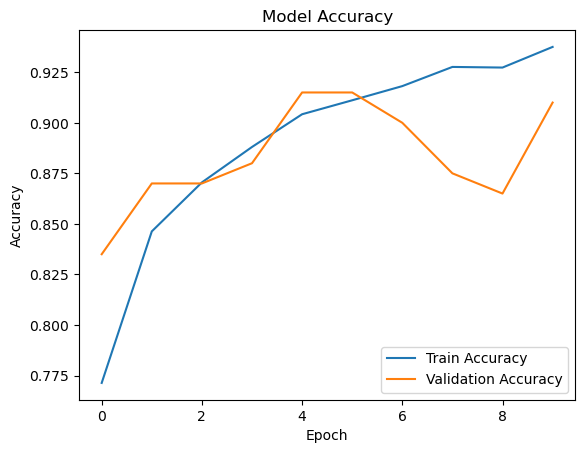

In [14]:
plot_model_accuracy(history)

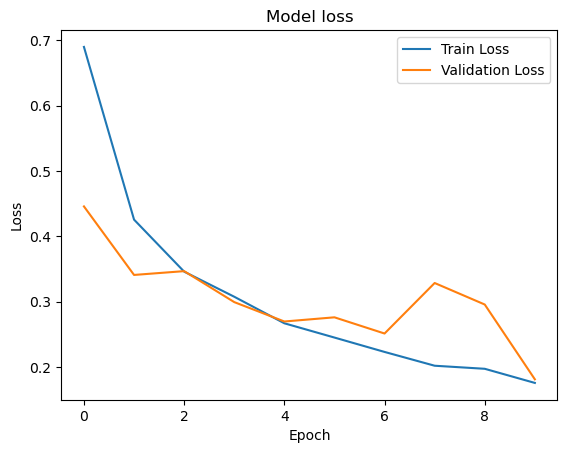

In [15]:
plot_model_loss(history)

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 31s 7s/step - loss: 0.2687 - accuracy: 0.9200
Test Loss: 0.26869839429855347
Test Accuracy: 0.9200000166893005


In terms of accuracy, the model shows a very good one of 92%, but we can see from the charts the fluctuation in the validation accuracy

As the model shows an accepted performance, now its time to optimize and find the best possible model 

## Optimization

In this section, we will exprirement with batch size, activation funcion, dropout and Dense layer connections 

### Batch Size

#### batch_size=64

In [18]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=64, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=64, shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=64, shuffle=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Epoch 1/10
152/152 [==============================] - 2934s 19s/step - loss: 0.6717 - accuracy: 0.7740 - val_loss: 0.3244 - val_accuracy: 0.8750
Epoch 2/10
152/152 [==============================] - 2910s 19s/step - loss: 0.3986 - accuracy: 0.8549 - val_loss: 0.2624 - val_accuracy: 0.8850
Epoch 3/10
152/152 [==============================] - 2911s 19s/step - loss: 0.3383 - accuracy: 0.8780 - val_loss: 0.2777 - val_accuracy: 0.9000
Epoch 4/10
152/152 [==============================] - 2916s 19s/step - loss: 0.2998 - accuracy: 0.8891 - val_loss: 0.2787 - val_accuracy: 0.8850
Epoch 5/10
152/152 [==============================] - 2912s 19s/step - loss: 0.2588 - accuracy: 0.9073 - val_loss: 0.3244 - val_accuracy: 0.8850
Epoch 6/10
152/152 [==============================] - 2912s 19s/step - loss: 0.2395 - accuracy: 0.9145 - val_loss: 0.2983 - val_accuracy: 0.8850
Epoch 

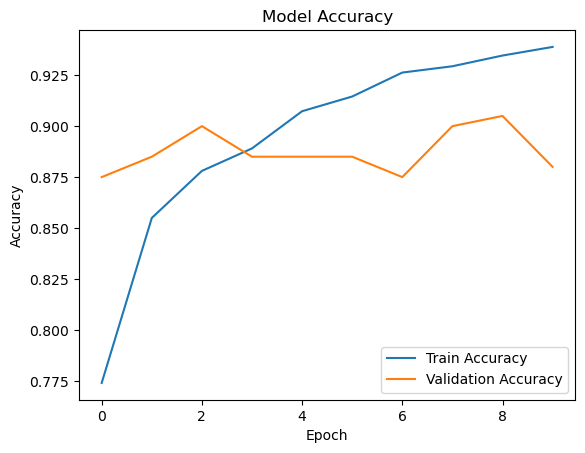

In [19]:
plot_model_accuracy(history)

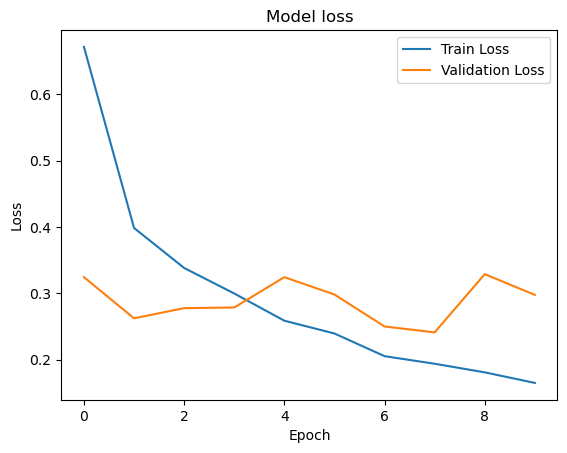

In [20]:
plot_model_loss(history)

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 31s 12s/step - loss: 0.3114 - accuracy: 0.8900
Test Loss: 0.31142735481262207
Test Accuracy: 0.8899999856948853


The model has shown a better performance when the batch size was 32, in terms of accuracy and overfitting. Therefore we have to expirement with lower batch size 

#### batch_size=16

In [24]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=16, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=16, shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=16, shuffle=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Epoch 1/10
607/607 [==============================] - 3347s 5s/step - loss: 0.6621 - accuracy: 0.7687 - val_loss: 0.4208 - val_accuracy: 0.8500
Epoch 2/10
607/607 [==============================] - 3449s 6s/step - loss: 0.4284 - accuracy: 0.8401 - val_loss: 0.3426 - val_accuracy: 0.8350
Epoch 3/10
607/607 [==============================] - 3508s 6s/step - loss: 0.3618 - accuracy: 0.8669 - val_loss: 0.4224 - val_accuracy: 0.8650
Epoch 4/10
607/607 [==============================] - 3684s 6s/step - loss: 0.3165 - accuracy: 0.8847 - val_loss: 0.2629 - val_accuracy: 0.8950
Epoch 5/10
607/607 [==============================] - 3530s 6s/step - loss: 0.2931 - accuracy: 0.8948 - val_loss: 0.3640 - val_accuracy: 0.8800
Epoch 6/10
607/607 [==============================] - 3281s 5s/step - loss: 0.2585 - accuracy: 0.9045 - val_loss: 0.3101 - val_accuracy: 0.8800
Epoch 7/10
6

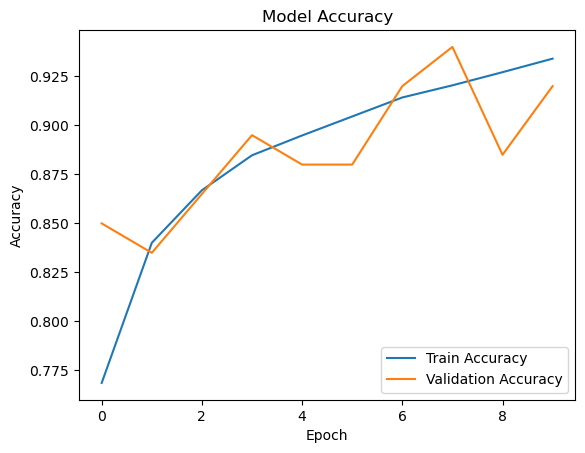

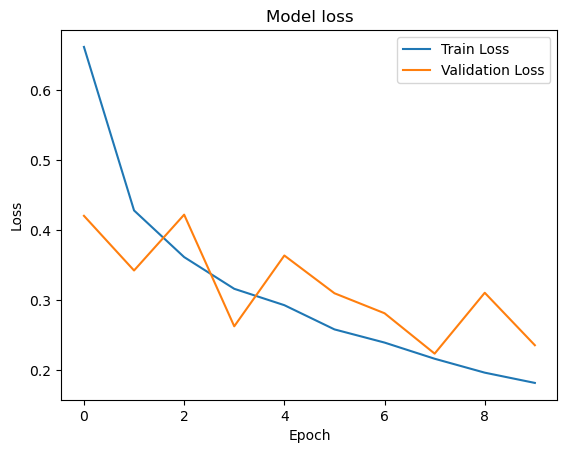

In [25]:
plot_model_accuracy(history)
plot_model_loss(history)

In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 30s 4s/step - loss: 0.3782 - accuracy: 0.8900
Test Loss: 0.37815532088279724
Test Accuracy: 0.8899999856948853


Same case as batch size of 64, so we will stick with 32

### Activation Funcion


#### Leaky relu

In [28]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Epoch 1/10
304/304 [==============================] - 3099s 10s/step - loss: 0.7553 - accuracy: 0.7698 - val_loss: 0.4020 - val_accuracy: 0.8700
Epoch 2/10
304/304 [==============================] - 3098s 10s/step - loss: 0.4382 - accuracy: 0.8410 - val_loss: 0.3154 - val_accuracy: 0.8950
Epoch 3/10
304/304 [==============================] - 3100s 10s/step - loss: 0.3785 - accuracy: 0.8630 - val_loss: 0.3201 - val_accuracy: 0.8650
Epoch 4/10
304/304 [==============================] - 3074s 10s/step - loss: 0.3252 - accuracy: 0.8820 - val_loss: 0.3426 - val_accuracy: 0.8600
Epoch 5/10
304/304 [==============================] - 3073s 10s/step - loss: 0.3231 - accuracy: 0.8788 - val_loss: 0.3067 - val_accuracy: 0.8550
Epoch 6/10
304/304 [==============================] - 3074s 10s/step - loss: 0.2774 - accuracy: 0.8997 - val_loss: 0.2755 - val_accuracy: 0.9050
Epoch 

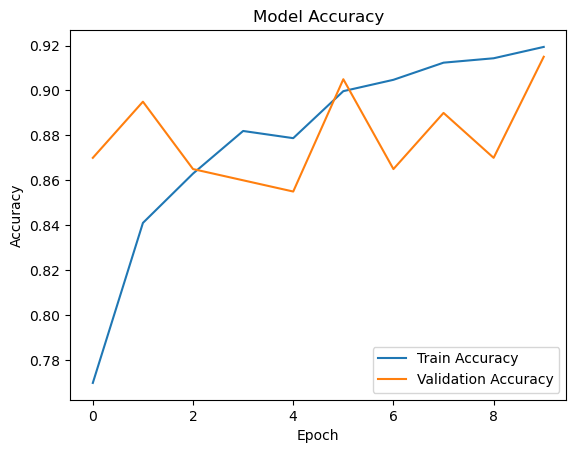

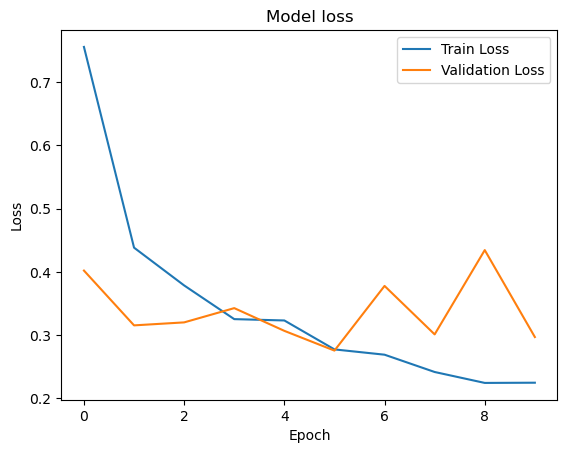

In [29]:
plot_model_accuracy(history)
plot_model_loss(history)

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 34s 8s/step - loss: 0.3725 - accuracy: 0.8700
Test Loss: 0.37252944707870483
Test Accuracy: 0.8700000047683716


Worst accuracy, we will stick to Relu

### Optimizer

#### SGD

In [31]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, shuffle=False)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Epoch 1/10
304/304 [==============================] - 3100s 10s/step - loss: 1.0612 - accuracy: 0.5997 - val_loss: 0.7584 - val_accuracy: 0.7250
Epoch 2/10
304/304 [==============================] - 3101s 10s/step - loss: 0.6973 - accuracy: 0.7510 - val_loss: 0.6259 - val_accuracy: 0.8050
Epoch 3/10
304/304 [==============================] - 3118s 10s/step - loss: 0.6043 - accuracy: 0.7874 - val_loss: 0.5539 - val_accuracy: 0.8200
Epoch 4/10
304/304 [==============================] - 3132s 10s/step - loss: 0.5512 - accuracy: 0.8045 - val_loss: 0.5100 - val_accuracy: 0.8250
Epoch 5/10
304/304 [==============================] - 3083s 10s/step - loss: 0.5193 - accuracy: 0.8148 - val_loss: 0.4760 - val_accuracy: 0.8200
Epoch 6/10
304/304 [==============================] - 3126s 10s/step - loss: 0.4915 - accuracy: 0.8306 - val_loss: 0.4578 - val_accuracy: 0.8300
Epoch 

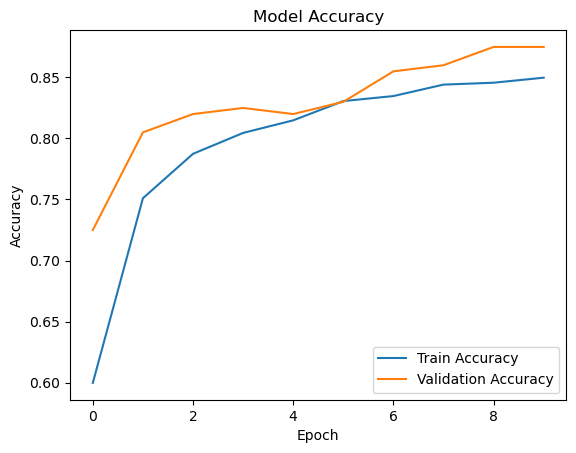

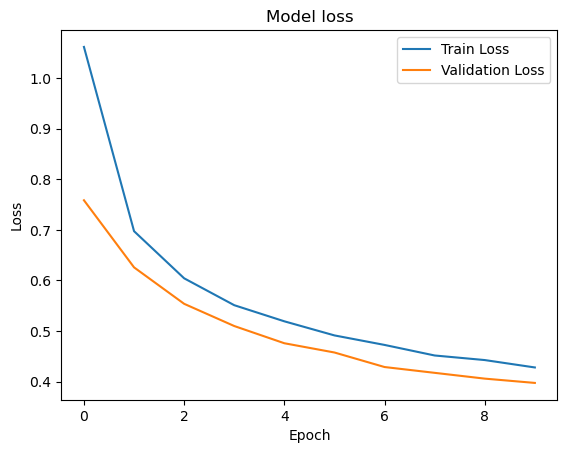

In [32]:
plot_model_accuracy(history)
plot_model_loss(history)

In [33]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 32s 7s/step - loss: 0.4082 - accuracy: 0.8400
Test Loss: 0.4081645905971527
Test Accuracy: 0.8399999737739563


### Regulization

### Dropout

In [34]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
304/304 [==============================] - 3229s 11s/step - loss: 0.7889 - accuracy: 0.7324 - val_loss: 0.4278 - val_accuracy: 0.8350
Epoch 2/10
304/304 [==============================] - 3158s 10s/step - loss: 0.5501 - accuracy: 0.7971 - val_loss: 0.3103 - val_accuracy: 0.8850
Epoch 3/10
304/304 [==============================] - 3089s 10s/step - loss: 0.4704 - accuracy: 0.8239 - val_loss: 0.3057 - val_accuracy: 0.8850
Epoch 4/10
304/304 [==============================] - 2907s 10s/step - loss: 0.4314 - accuracy: 0.8386 - val_loss: 0.3062 - val_accuracy: 0.9050
Epoch 5/10
304/304 [==============================] - 2927s 10s/step - loss: 0.4123 - accuracy: 0.8481 - val_loss: 0.3025 - val_accuracy: 0.8850
Epoch 6/10
304/304 [==============================] - 2915s 10s/step - loss: 0.3950 - accuracy: 0.8578 - val_loss: 0.2549 - val_accuracy: 0.9050
Epoch 7/10
304/304 [==============================] - 2911s 10s/step - loss: 0.3785 - accuracy: 0.8611 - val_loss: 0.2841 - val_ac

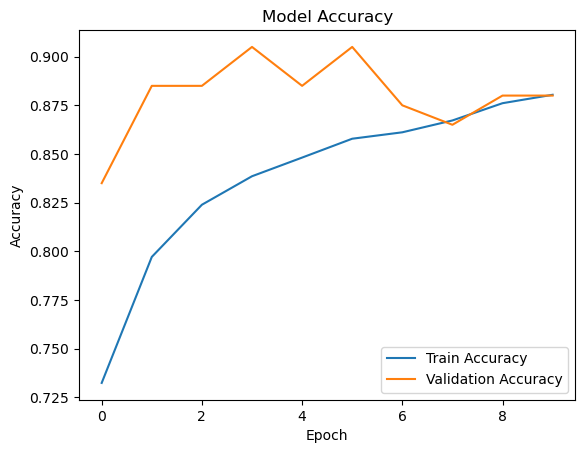

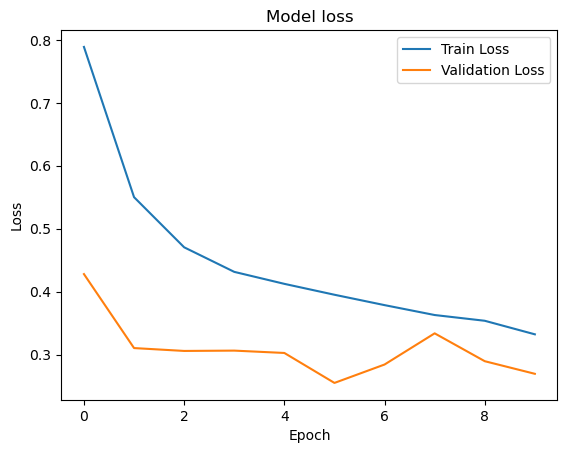

In [35]:
plot_model_accuracy(history)
plot_model_loss(history)

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 29s 7s/step - loss: 0.2795 - accuracy: 0.9400
Test Loss: 0.279493510723114
Test Accuracy: 0.9399999976158142


This model would be better than the first model, and therefore its the best so far, due to some reasons:

1- the gap between the training and validation accuracy is lower, although the trianing accuracy is better in the first model

2- most importantly, the test accuracy is 94% comparing to the first model 92%. indicating that the model generalizes better


### Desne Connections

In [38]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet152 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10
304/304 [==============================] - 3225s 11s/step - loss: 0.7819 - accuracy: 0.7241 - val_loss: 0.3826 - val_accuracy: 0.8500
Epoch 2/10
304/304 [==============================] - 3302s 11s/step - loss: 0.5377 - accuracy: 0.8041 - val_loss: 0.3654 - val_accuracy: 0.8550
Epoch 3/10
304/304 [==============================] - 3216s 11s/step - loss: 0.4852 - accuracy: 0.8273 - val_loss: 0.3383 - val_accuracy: 0.8550
Epoch 4/10
304/304 [==============================] - 3182s 10s/step - loss: 0.4574 - accuracy: 0.8310 - val_loss: 0.3444 - val_accuracy: 0.8700
Epoch 5/10
304/304 [==============================] - 3983s 13s/step - loss: 0.4269 - accuracy: 0.8449 - val_loss: 0.3259 - val_accuracy: 0.8500
Epoch 6/10
304/304 [==============================] - 3157s 10s/step - loss: 0.4047 - accuracy: 0.8570 - val_loss: 0.2619 - val_accuracy: 0.8900
Epoch 7/10
304/304 [==============================] - 3156s 10s/step - loss: 0.3924 - accuracy: 0.8567 - val_loss: 0.2704 - val_ac

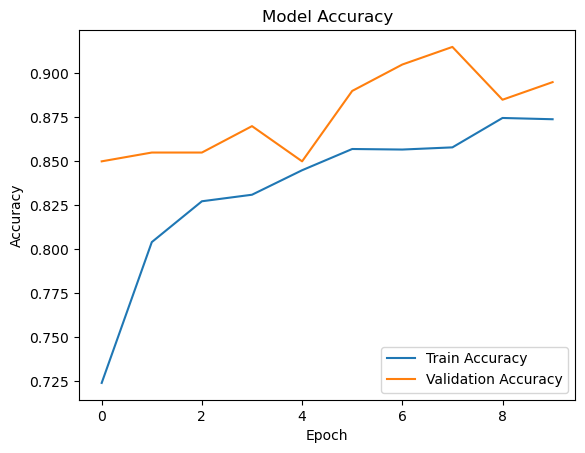

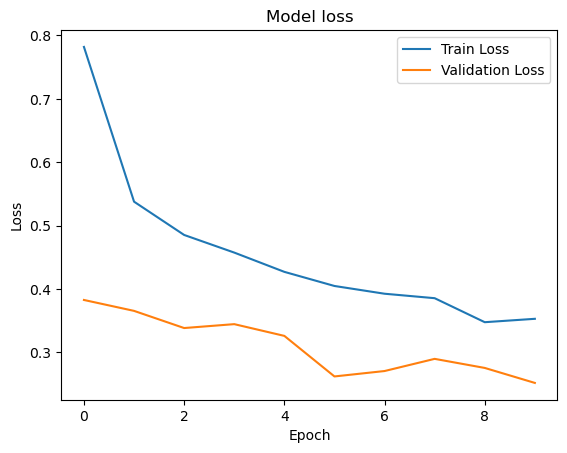

In [40]:
plot_model_accuracy(history)
plot_model_loss(history)

In [39]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 [==============================] - 25s 6s/step - loss: 0.2624 - accuracy: 0.9100
Test Loss: 0.2624206840991974
Test Accuracy: 0.9100000262260437


Although the model generlizes well, still the previous model is better in terms of accuracy

## Conclusion

Based on above expirements, the best model was the initial model + Dropout layer. The following table summerizes the expirements 

| Model | Change              | Test Accuracy |
|-------|---------------------|---------------|
| 1     | Base                | 92%           |
| 2     | batch size = 64     | 89%           |
| 3     | batch size = 16     | 89%           |
| 4     | Leaky Relu          | 87%           |
| 5     | SGD Optimizer       | 84%           |
| 6     | Dropout             | 94%           |
| 7     | Dense layer (256)   | 91%           |
